<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

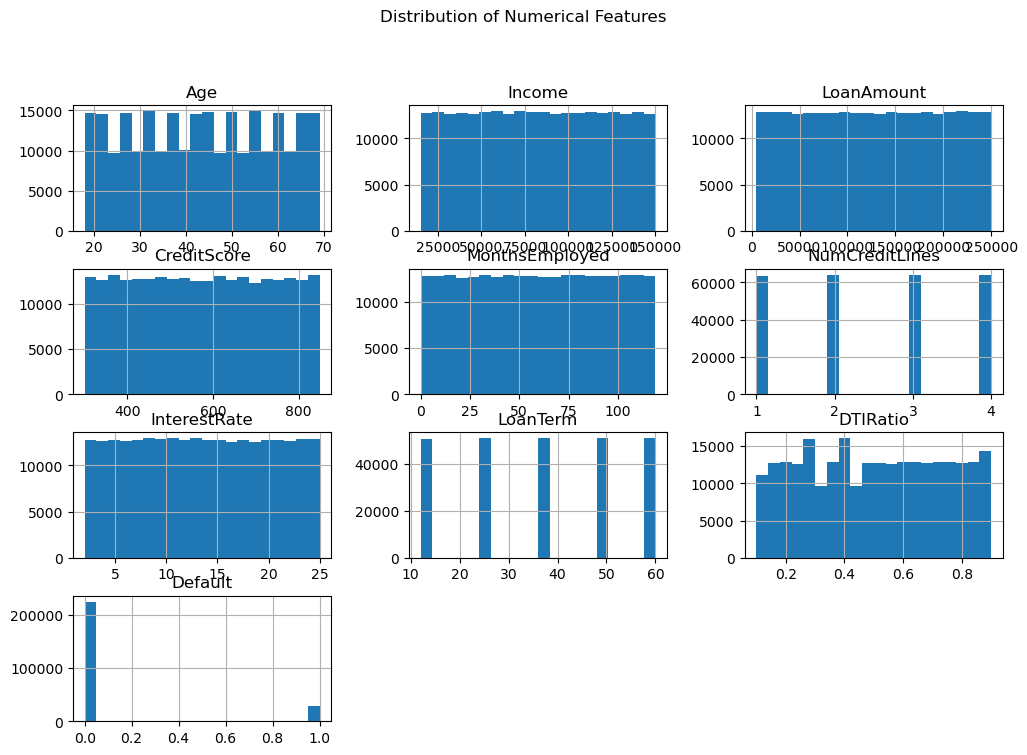

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv('Loan_default.csv')
print(data.info())
print(data.head())
print(data.isnull().sum())

data = pd.get_dummies(data, columns = ['HasCoSigner', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose'], drop_first=True)
print(data.columns)
print(data.info())

numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_features].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Numerical Features', y=1.0)
plt.show()



In [83]:
bool_to_float = lambda x: float(x) if isinstance(x, bool) else x
columns_to_convert = ['Education_High School',
                      "Education_Master's", 'Education_PhD', 'EmploymentType_Part-time',
                      'EmploymentType_Self-employed', 'EmploymentType_Unemployed',
                      'MaritalStatus_Married', 'MaritalStatus_Single', 'HasMortgage_Yes',
                      'HasDependents_Yes', 'LoanPurpose_Business', 'LoanPurpose_Education',
                      'LoanPurpose_Home', 'LoanPurpose_Other', 'HasCoSigner_Yes']
data[columns_to_convert] = data[columns_to_convert].applymap(bool_to_float)

print(data.info)

/var/folders/0c/czd_d5rs7n940gdfw_g_m1w80000gn/T/ipykernel_4707/4153539853.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[columns_to_convert] = data[columns_to_convert].applymap(bool_to_float)


<bound method DataFrame.info of             LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0       I38PQUQS96   56   85994       50587          520              80   
1       HPSK72WA7R   69   50432      124440          458              15   
2       C1OZ6DPJ8Y   46   84208      129188          451              26   
3       V2KKSFM3UN   32   31713       44799          743               0   
4       EY08JDHTZP   60   20437        9139          633               8   
...            ...  ...     ...         ...          ...             ...   
255342  8C6S86ESGC   19   37979      210682          541             109   
255343  98R4KDHNND   32   51953      189899          511              14   
255344  XQK1UUUNGP   56   84820      208294          597              70   
255345  JAO28CPL4H   42   85109       60575          809              40   
255346  ZTH91CGL0B   62   22418       18481          636             113   

        NumCreditLines  InterestRate  LoanTerm  DTIRati

In [84]:
print(data.describe())

                 Age         Income     LoanAmount    CreditScore  \
count  255347.000000  255347.000000  255347.000000  255347.000000   
mean       43.498306   82499.304597  127578.865512     574.264346   
std        14.990258   38963.013729   70840.706142     158.903867   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48825.500000   66156.000000     437.000000   
50%        43.000000   82466.000000  127556.000000     574.000000   
75%        56.000000  116219.000000  188985.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255347.000000   255347.000000  255347.000000  255347.000000   
mean        59.541976        2.501036      13.492773      36.025894   
std         34.643376        1.117018       6.636443      16.969330   
min          0.000000        1.000000       2.000000      12.000000   
25%         30.000000  

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


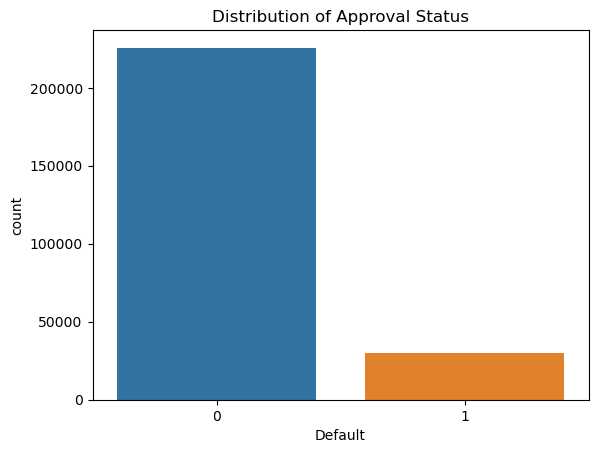

In [85]:
sns.countplot(x='Default', data=data)
plt.title('Distribution of Approval Status')
plt.show()

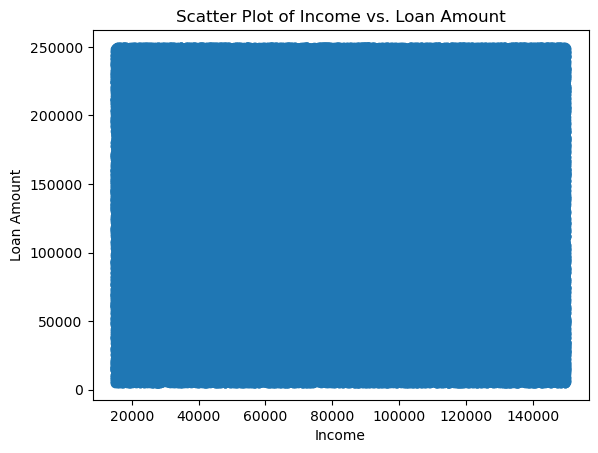

In [86]:
plt.scatter(data['Income'], data['LoanAmount'])
plt.title('Scatter Plot of Income vs. Loan Amount')
plt.xlabel('Income')
plt.ylabel('Loan Amount')
plt.show()

In [87]:
column_to_drop = 'LoanID'
data = data.drop(column_to_drop, axis = 1)
print(data.head())

   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   56   85994       50587          520              80               4   
1   69   50432      124440          458              15               1   
2   46   84208      129188          451              26               3   
3   32   31713       44799          743               0               3   
4   60   20437        9139          633               8               4   

   InterestRate  LoanTerm  DTIRatio  Default  ...  \
0         15.23        36      0.44        0  ...   
1          4.81        60      0.68        0  ...   
2         21.17        24      0.31        1  ...   
3          7.07        24      0.23        0  ...   
4          6.51        48      0.73        0  ...   

   EmploymentType_Self-employed  EmploymentType_Unemployed  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0             

In [88]:
print(data.head())

   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   56   85994       50587          520              80               4   
1   69   50432      124440          458              15               1   
2   46   84208      129188          451              26               3   
3   32   31713       44799          743               0               3   
4   60   20437        9139          633               8               4   

   InterestRate  LoanTerm  DTIRatio  Default  ...  \
0         15.23        36      0.44        0  ...   
1          4.81        60      0.68        0  ...   
2         21.17        24      0.31        1  ...   
3          7.07        24      0.23        0  ...   
4          6.51        48      0.73        0  ...   

   EmploymentType_Self-employed  EmploymentType_Unemployed  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0             

In [89]:
print(data.corr())

                                   Age    Income  LoanAmount  CreditScore  \
Age                           1.000000 -0.001244   -0.002213    -0.000548   
Income                       -0.001244  1.000000   -0.000865    -0.001430   
LoanAmount                   -0.002213 -0.000865    1.000000     0.001261   
CreditScore                  -0.000548 -0.001430    0.001261     1.000000   
MonthsEmployed               -0.000341  0.002675    0.002817     0.000613   
NumCreditLines               -0.000890 -0.002016    0.000794     0.000016   
InterestRate                 -0.001127 -0.002303   -0.002291     0.000436   
LoanTerm                      0.000263 -0.000998    0.002538     0.001130   
DTIRatio                     -0.004689  0.000205    0.001122    -0.001039   
Default                      -0.167783 -0.099119    0.086659    -0.034166   
HasCoSigner_Yes              -0.002918 -0.003524   -0.001848    -0.002755   
Education_High School         0.000269 -0.003042   -0.001510     0.001993   

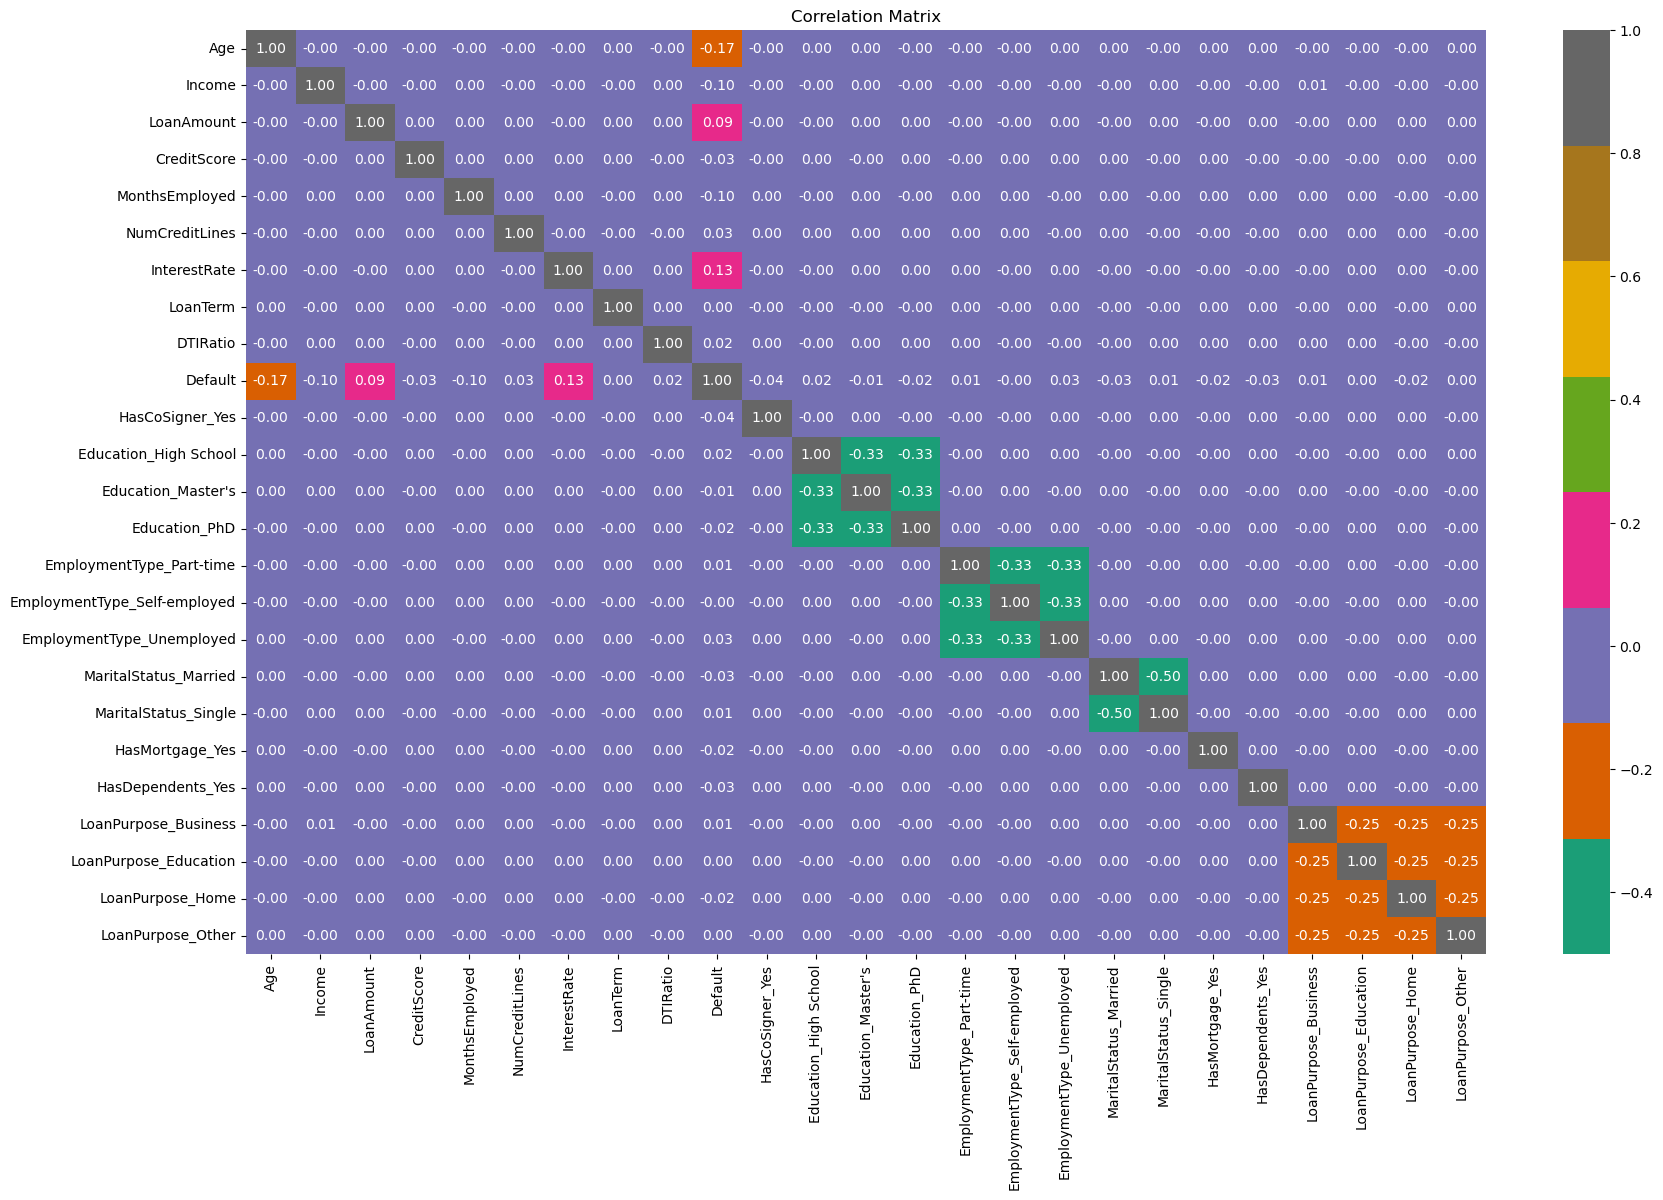

In [90]:
corr_matrix = data.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, cmap='Dark2', fmt='.2f', )
plt.title('Correlation Matrix')
plt.show()

In [91]:
print(data['Income'].describe())

count    255347.000000
mean      82499.304597
std       38963.013729
min       15000.000000
25%       48825.500000
50%       82466.000000
75%      116219.000000
max      149999.000000
Name: Income, dtype: float64


In [92]:
# Dataset with features
X = data.drop('Default', axis = 1)

# Target variable
y=data['Default']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logisitic Regression Model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

'''Not great results. Too many False Negatives'''

Accuracy: 0.885823379674956
Confusion Matrix:
[[45046   124]
 [ 5707   193]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.61      0.03      0.06      5900

    accuracy                           0.89     51070
   macro avg       0.75      0.51      0.50     51070
weighted avg       0.86      0.89      0.84     51070



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


'Not great results. Too many False Negatives'

In [93]:
def treat_outliers(df,col):
    '''
    treats outliers in a variable
    df: data frame
    col: name of the column
    '''

    Q1 = np.nanquantile(df[col], 0.25) # 25th quantile
    Q3 = np.nanquantile(df[col], 0.75)  # 75th quantile
    IQR = Q3 - Q1   # IQR Range
    Lower_Whisker = Q1 - 1.5*IQR  #define lower whisker
    Upper_Whisker = Q3 + 1.5*IQR  # define upper Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker
    # and all the values above upper_whishker will be assigned value of upper_Whisker
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)

    return df
numerical_cols = data.columns[0:8]
print(numerical_cols)

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm'],
      dtype='object')


In [94]:
treat_outliers_all(data, numerical_cols)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,56,85994,50587,520,80,4,15.23,36,0.44,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,69,50432,124440,458,15,1,4.81,60,0.68,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,46,84208,129188,451,26,3,21.17,24,0.31,1,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,32,31713,44799,743,0,3,7.07,24,0.23,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
255343,32,51953,189899,511,14,2,11.55,24,0.21,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
255344,56,84820,208294,597,70,3,5.29,60,0.50,0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
255345,42,85109,60575,809,40,1,20.90,48,0.44,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [95]:
data.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,...,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128,...,0.249488,0.249950,0.334063,0.332927,0.500014,0.500268,0.200895,0.199748,0.200848,0.199391
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379,...,0.432718,0.432985,0.471663,0.471262,0.500001,0.500001,0.400671,0.399812,0.400636,0.399544
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
sm = SMOTE(random_state = 42)
X_res, Y_res = sm.fit_resample(X, y)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, Y_res, test_size = 0.30, random_state = 42)


print("Shape of the training set: ", X_train_res.shape)

print("Shape of the test set: ", X_test_res.shape)

print("Percentage of classes in the training set:")

print(y_train_res.value_counts(normalize = True))

print("Percentage of classes in the test set:")

print(y_test_res.value_counts(normalize = True))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Shape of the training set:  (315971, 24)
Shape of the test set:  (135417, 24)
Percentage of classes in the training set:
Default
0    0.500112
1    0.499888
Name: proportion, dtype: float64
Percentage of classes in the test set:
Default
1    0.500262
0    0.499738
Name: proportion, dtype: float64


In [97]:
#creating metric function
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


# Training XGBoost across 10 folds with GridSearchCV
xgb_estimator_tuned_smote = XGBClassifier(booster = "gbtree", random_state = 42, n_jobs=4)

# Grid of parameters to choose from
parameters = {'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'learning_rate': [0.30000012],
              'max_bin':[256],
              'n_estimators':[100, 200]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(xgb_estimator_tuned_smote, parameters, scoring = scorer, cv = 10)

#fit the GridSearch on train dataset
grid_obj = grid_obj.fit(X_train_res, y_train_res)

# Set the clf to the best combination of parameters
xgb_estimator_tuned_smote = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_estimator_tuned_smote.fit(X_train_res, y_train_res)

# evaluating the model on the testing set
y_pred_test = xgb_estimator_tuned_smote.predict(X_test_res)
metrics_score(y_test_res, y_pred_test)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/anacon

KeyboardInterrupt: 